In [1]:
# Google colab setup.
import subprocess

def setup_google_colab_execution():
    subprocess.run(["git", "clone", "https://github.com/bookingcom/uplift-modeling-for-marketing-personalization-tutorial"]) 
    subprocess.run(["pip", "install", "-r", "uplift-modeling-for-marketing-personalization-tutorial/requirements-colab.txt"]) 
    subprocess.run(["cp", "uplift-modeling-for-marketing-personalization-tutorial/tutorial/notebooks/utils.py", "./"])

running_on_google_colab = False # Set this to true if you're running this notebook on google colab

if running_on_google_colab:
    setup_google_colab_execution()

# Incremental Profit per Conversion (IPC) Method

## 1. Introduction

In e-commerce settings, promotions such as discounts or coupons often incur costs only when a conversion occurs. Traditional uplift modeling approaches focus on conversion rates, but they do not directly account for profit. To address this, **Incremental Profit per Conversion (IPC)** focuses on the incremental profit generated by a promotion, making it a more relevant metric for businesses focused on profitability rather than just increasing conversions. [Link to paper](https://arxiv.org/pdf/2306.13759).

## 2. The IPC Formula

For a given context \( $\mathbf{x}$ \), IPC is defined as:

$$
\text{IPC}(\mathbf{x}) = \frac{\mathbb{E}[\pi | \mathbf{x}, T=1] - \mathbb{E}[\pi | \mathbf{x}, T=0]}{\mathbb{P}(C = 1 | \mathbf{x})}
$$

Where:
- \( $\pi$ \) represents profit, defined as \( $\text{revenue}$ - $\text{cost}$ \).
- \( $C$ \) indicates conversion (1 for conversion, 0 otherwise).
- \( $T$ \) is the treatment indicator (1 for promotion applied, 0 for no promotion).

This formula estimates the incremental profit per conversion given a particular context. The higher the IPC, the more effective the promotion in generating profit.

## 3. Response Transformation Method

The IPC method relies on a response transformation that only uses converted data. This transformation mitigates noise from non-converted data and improves model performance by focusing only on instances where profit is realized.

### The Response Transformation Formula

For each instance, the transformed response variable \( $Z_i$ \) is defined as:

$$
Z_i = \begin{cases} 
- \frac{\pi_i}{\mathbb{P}(T=0 | \mathbf{x})} & \text{if } T_i = 0 \text{ and } C_i = 1 \\
+ \frac{\pi_i}{\mathbb{P}(T=1 | \mathbf{x})} & \text{if } T_i = 1 \text{ and } C_i = 1 \\
\text{remove instance} & \text{if } C_i = 0
\end{cases}
$$

### Key Advantages
1. **Profit-Focused**: IPC directly models profit, aligning with business objectives.
2. **Efficient**: By only using converted data, it reduces noise and class imbalance, leading to faster training times and more robust predictions.
3. **Applicability**: The method is especially useful in e-commerce scenarios where only conversions incur costs (e.g., coupons, discounts).

## 4. Python Implementation of IPC

Below is a code example demonstrating the IPC method in Python:

### Step 1: Collect Data

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

# Step 1: Generate Synthetic Data
np.random.seed(42)
n_samples = 10000
n_features = 5

# Generate random features
X = np.random.normal(0, 1, size=(n_samples, n_features))

# Simulate treatment assignment (0: control, 1: treatment)
T = np.random.binomial(1, 0.5, n_samples)

# Simulate conversion (1: converted, 0: not converted)
C = (np.random.rand(n_samples) < 0.3 + 0.2 * (X[:, 0] > 0)).astype(int)

# Simulate profit for each instance (only if converted)
revenue = np.exp(X[:, 0] + X[:, 1])  # Revenue follows an exponential distribution
cost = np.random.normal(10, 2, n_samples) * T  # Cost applies only when treated
profit = revenue - cost
profit[C == 0] = 0  # Profit is zero for non-converted instances

### Step 2: Apply Response Transformation

In [3]:
def response_transformation(profit, T, C, propensity_treated=0.5, propensity_control=0.5):
    Z = np.zeros_like(profit)
    for i in range(len(profit)):
        if C[i] == 1:
            if T[i] == 1:
                Z[i] = profit[i] / propensity_treated
            else:
                Z[i] = -profit[i] / propensity_control
    return Z

Z = response_transformation(profit, T, C)

# Create DataFrame for easier handling
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
df['T'] = T
df['C'] = C
df['profit'] = profit
df['Z'] = Z

# Filter out non-converted data
df_converted = df[df['C'] == 1]

### Step 3: Train a Regression Model to Estimate IPC

In [4]:
X_converted = df_converted.drop(columns=['T', 'C', 'profit', 'Z'])
y_converted = df_converted['Z']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_converted, y_converted, test_size=0.3, random_state=42)

# Train LightGBM model
model = LGBMRegressor()
model.fit(X_train, y_train)

# Predict IPC for the test set
ipc_predictions = model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 2783, number of used features: 5
[LightGBM] [Info] Start training from score -10.163055


### Step 4: Evaluate and Visualize Results

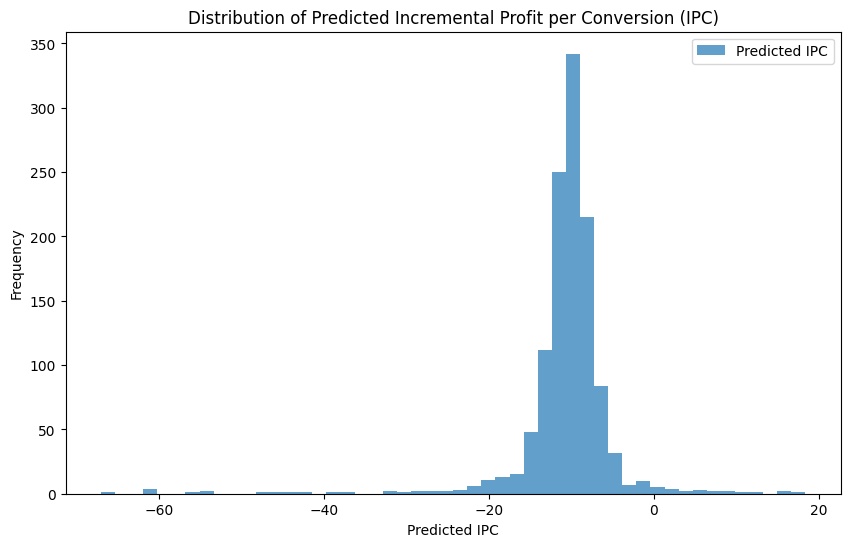

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(ipc_predictions, bins=50, alpha=0.7, label='Predicted IPC')
plt.title('Distribution of Predicted Incremental Profit per Conversion (IPC)')
plt.xlabel('Predicted IPC')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## 5. Comparison of IPC with other Uplift Models

The results below show that IPC performs on par or better than other algorithms, taking 100 times less time if you use non-converted data. Below we can see the comparison between methods extracted from the [IPC paper](https://arxiv.org/pdf/2306.13759).

![IPC Performance](../images/ipc_performance.png)
